# Phase estimation with QCNN (N = 8)

Reproducing results from: https://arxiv.org/abs/1906.10155

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
dev_vqe = qml.device('default.qubit', wires=8)

## States preparation through VQE

In [3]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
        
    # Ising Ring
    # H = H + J*(-1)*( qml.PauliX(0) @ qml.PauliX(N-1) )
    
    return H

def vqe_circuit_1(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    for spin in range(N):
        qml.RY(param[spin], wires = spin)
        qml.RX(param[N+spin], wires = spin)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    for spin in range(N):
        qml.RY(param[2*N   + spin], wires = spin)
        qml.RX(param[3*N   + spin], wires = spin)
    
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
        
    for spin in range(N):
        qml.RY(param[4*N + spin], wires = spin)
        
def vqe_circuit_2(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    qml.RY(param[0], wires = 0)
    qml.RX(param[1], wires = 0)
    
    qml.RY(param[2], wires = N - 1)
    qml.RX(param[3], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[4], wires = spin)
        qml.RY(param[5], wires = spin+1)
        qml.RX(param[6], wires = spin)
        qml.RX(param[7], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    qml.RY(param[8], wires = 0)
    qml.RX(param[9], wires = 0)
    
    qml.RY(param[10], wires = N - 1)
    qml.RX(param[11], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[12], wires = spin)
        qml.RY(param[13], wires = spin+1)
        qml.RX(param[14], wires = spin)
        qml.RX(param[15], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
     
    qml.RX(param[16], wires = 0)
    qml.RX(param[17], wires = N - 1)
    
    qml.RY(param[18], wires = 0)
    qml.RY(param[19], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RX(param[20], wires = spin)
        qml.RX(param[21], wires = spin+1)
        qml.RY(param[22], wires = spin)
        qml.RY(param[23], wires = spin+1)
        
def show_params_ising_chain(thetas_arr):
    '''
    thetas_arr: array of the following structure:
                    list( (J_value, angles of the circuit (vqe_ising_chain_circuit) ) )
    '''
    for J in range(len(thetas_arr)):
        plt.title('J = {0}'.format(thetas_arr[J][0])) 

        pm = plt.imshow(np.abs(thetas_arr[J][1]))

        for i in range(np.shape(thetas_arr[J][1])[1]):
            plt.axvline(x=i - .5, color = 'black')

        plt.ylabel(r'$\lambda$')

        plt.colorbar(pm, shrink=0.3, aspect=20)
        plt.tight_layout()
        plt.show()    
        
def train_vqe_ising(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size = Step size of the optimizer
    epochs    = # epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (# epochs for each lambda)'.format(n_epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    
    lams = np.linspace(0,2*J,l_steps)
    
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    @qml.qnode(dev_vqe)
    def cost_fn(param):
        vqe_circuit_1(param, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    thetas = np.array(np.random.randn(5*N), requires_grad = True) # Prepare initial state
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)
        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys      

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-2.56)──RX(-0.18)─╭C────────────────────||──RY(0.36)───RX(1.24)──╭C──RY(0.68)───────────
1: ──RY(-0.25)──RX(-1.79)─╰X─╭C─────────────────||──RY(-0.32)──RX(-0.22)─╰X─╭C─────────RY(-0.13)
2: ──RY(0.30)───RX(1.12)─────╰X─╭C──────────────||──RY(0.13)───RX(-0.14)────╰X────────╭C────────
3: ──RY(-0.87)──RX(2.15)────────╰X─╭C───────────||──RY(1.30)───RX(-0.60)──────────────╰X────────
4: ──RY(-0.19)──RX(0.73)───────────╰X─╭C────────||──RY(-0.40)──RX(-0.93)────────────────────────
5: ──RY(-0.05)──RX(0.20)──────────────╰X─╭C─────||──RY(-0.76)──RX(0.55)─────────────────────────
6: ──RY(-1.02)──RX(0.79)─────────────────╰X─╭C──||──RY(-1.87)──RX(-0.03)────────────────────────
7: ──RY(0.44)───RX(-0.56)───────────────────╰X──||──RY(-1.39)──RX(0.84)─────────────────────────

──────────────────────────────────────────────────────┤ ╭<𝓗>
──────────────────────────────────────────────────────┤ ├<𝓗>
───RY(0.65)───────────────────────────────────────────┤ ├<𝓗>
──╭C─────────RY(-1.19)──────────────────

  0%|          | 0/100 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


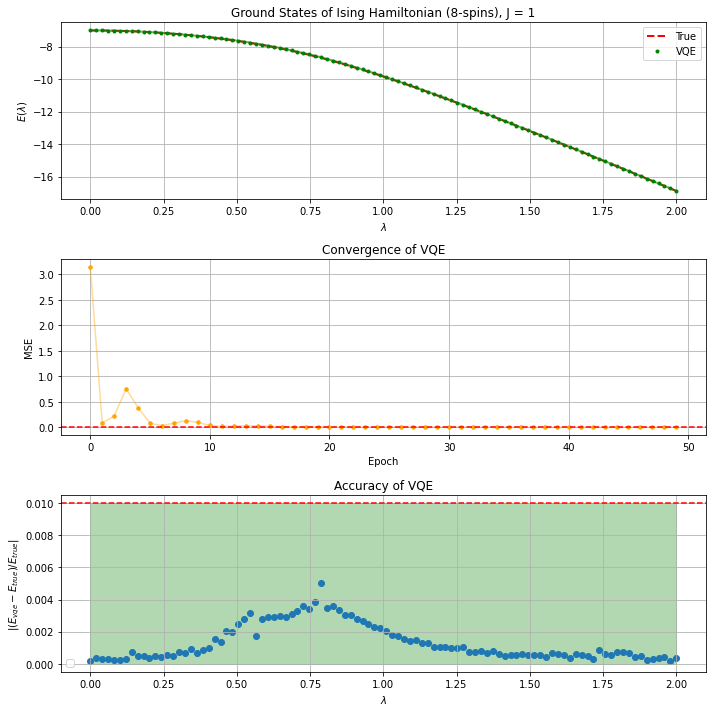

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.97)───RX(-1.65)─╭C────────────────────||──RY(0.65)───RX(-0.61)─╭C──RY(0.99)───────────
1: ──RY(1.33)───RX(1.53)──╰X─╭C─────────────────||──RY(1.36)───RX(0.81)──╰X─╭C─────────RY(-0.52)
2: ──RY(-0.79)──RX(2.21)─────╰X─╭C──────────────||──RY(0.09)───RX(1.45)─────╰X────────╭C────────
3: ──RY(-0.72)──RX(-0.12)───────╰X─╭C───────────||──RY(-0.72)──RX(1.59)───────────────╰X────────
4: ──RY(-0.01)──RX(0.45)───────────╰X─╭C────────||──RY(0.05)───RX(0.96)─────────────────────────
5: ──RY(0.92)───RX(-0.47)─────────────╰X─╭C─────||──RY(-2.18)──RX(-0.20)────────────────────────
6: ──RY(-0.18)──RX(-0.70)────────────────╰X─╭C──||──RY(1.67)───RX(-0.07)────────────────────────
7: ──RY(-0.33)──RX(-0.61)───────────────────╰X──||──RY(-0.46)──RX(0.47)─────────────────────────

──────────────────────────────────────────────────────┤ ╭<𝓗>
──────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-0.58)──────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(0.66)──────────────────

  0%|          | 0/100 [00:00<?, ?it/s]

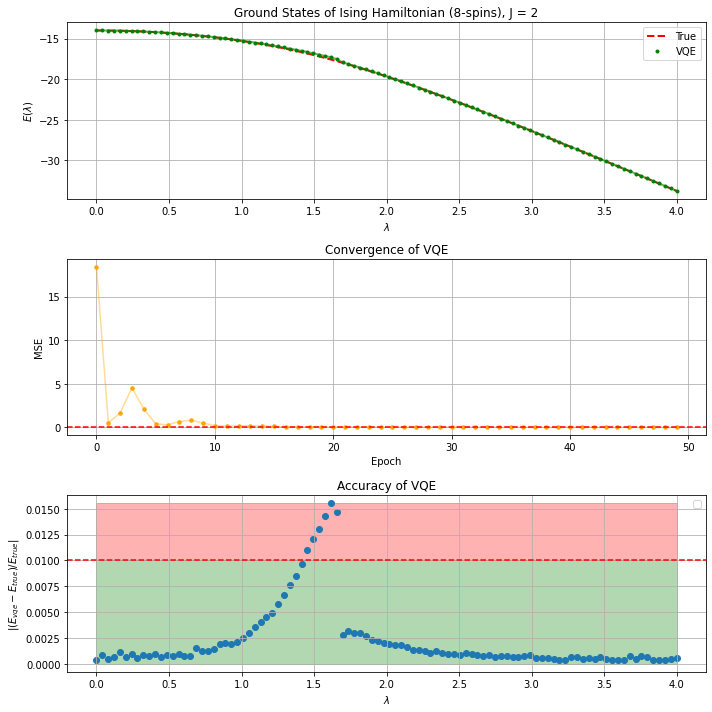

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-1.01)──RX(0.85)──╭C────────────────────||──RY(-0.61)──RX(-0.09)─╭C──RY(1.32)──────────
1: ──RY(0.77)───RX(0.62)──╰X─╭C─────────────────||──RY(-0.02)──RX(1.94)──╰X─╭C─────────RY(0.27)
2: ──RY(0.84)───RX(2.44)─────╰X─╭C──────────────||──RY(1.41)───RX(1.10)─────╰X────────╭C───────
3: ──RY(0.49)───RX(0.10)────────╰X─╭C───────────||──RY(-1.02)──RX(1.25)───────────────╰X───────
4: ──RY(-1.47)──RX(-1.31)──────────╰X─╭C────────||──RY(-1.40)──RX(0.47)────────────────────────
5: ──RY(0.37)───RX(1.17)──────────────╰X─╭C─────||──RY(-0.08)──RX(-0.50)───────────────────────
6: ──RY(1.12)───RX(-1.65)────────────────╰X─╭C──||──RY(2.31)───RX(-0.13)───────────────────────
7: ──RY(-1.36)──RX(-0.23)───────────────────╰X──||──RY(-1.11)──RX(2.12)────────────────────────

────────────────────────────────────────────────────────┤ ╭<𝓗>
────────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-0.66)────────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(1.27)────────────────────

  0%|          | 0/100 [00:00<?, ?it/s]

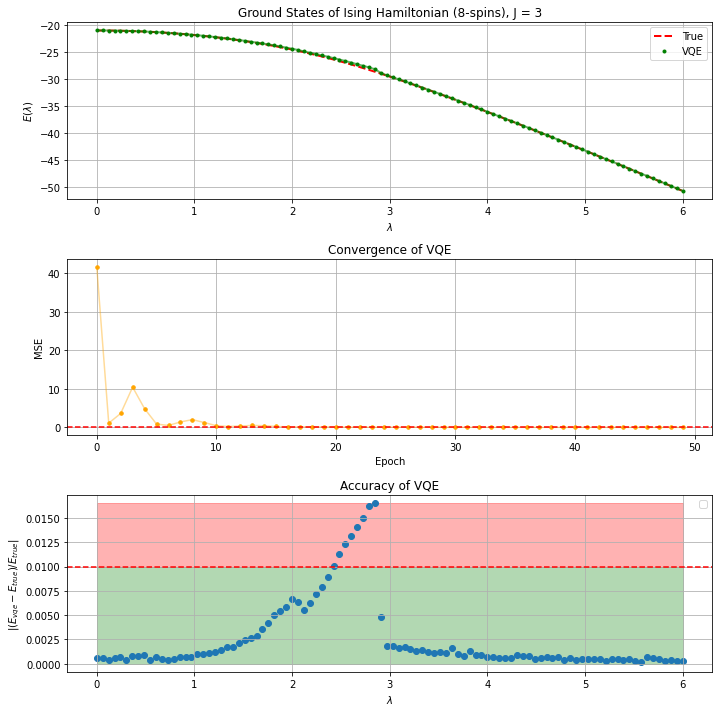

[[-1.570e+00 -2.000e-03  1.580e+00 ... -1.606e+00 -3.287e+00 -0.000e+00]
 [-1.485e+00  2.500e-02  1.554e+00 ... -1.458e+00 -3.199e+00 -2.600e-02]
 [-1.588e+00 -6.000e-03  1.486e+00 ... -1.550e+00 -2.977e+00 -4.000e-03]
 ...
 [-5.223e+00 -1.556e+00 -1.538e+00 ... -1.576e+00 -4.722e+00 -1.576e+00]
 [-4.937e+00 -1.541e+00 -1.587e+00 ... -1.563e+00 -4.703e+00 -1.557e+00]
 [-4.322e+00 -1.383e+00 -1.590e+00 ... -1.563e+00 -4.706e+00 -1.565e+00]]


/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [4]:
for it_j, J in enumerate([1,2,3]):
    vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.25, l_steps = 100, n_epochs = 50, N = 8, J = J,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)
    if it_j == 0:
        vqe_data_x = thetas 
        vqe_data_y = ys
    else:
        vqe_data_x = np.concatenate((vqe_data_x, thetas))
        vqe_data_y = np.concatenate((vqe_data_y, ys))
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_circuit_params.job')

print( np.round(np.asarray(thetas),3))

## Phase estimation through QCNN

In [5]:
dev_qcnn = qml.device('default.qubit.jax', wires=8)

In [6]:
# Load data and separate in training and test set
data_full = joblib.load('./vqe_circuit_params.job')

# Count the number of samples
samples_full = len(data_full)

data = data_full[:100]
samples = len(data)
print('Size of Data Set: {0}'.format(samples))

train_index = np.random.choice(np.arange(samples), size=int(0.8*samples), replace=False )

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [222]:
####################
## QCNN FUNCTIONS ##
####################
    
@qml.qnode(dev_qcnn, interface="jax", diff_method="best")     
def qcnn_8(params_vqe,params, N = 8):
    '''
    QCNN circuit:
    VQE STATE PREPARATION + CONVOLUTION + POOLING
    '''
    
    vqe_circuit_1(params_vqe, 8)
    qml.Barrier()
    
    k = 0
    
    # Even wires convolution
    for wire, wire_next in zip(range(0,N,2), range(1,N,2)):
        qml.RX(params[k], wires = wire)
        qml.RY(params[k+1], wires = wire)
        qml.CNOT(wires=[wire, wire_next])
        qml.RX(params[k+2], wires = wire)
        k = k + 3
    
    qml.Barrier()
    
    # Odd wires convolution
    for wire, wire_next in zip(range(N-2,0,-2), range(N-3,-1,-2)):
        qml.RX(params[k], wires = wire)
        qml.RY(params[k+1], wires = wire)
        qml.CNOT(wires=[wire, wire_next])
        qml.RX(params[k+2], wires = wire)
        k = k + 3
        
    qml.Barrier()
        
    for wire, wire_next in zip(range(N-1,-1,-2), range(N-2,-1,-2)):
        qml.RX(params[k], wires = wire)
        qml.RY(params[k+1], wires = wire)
        qml.CNOT(wires=[wire, wire_next])
        qml.RX(params[k+2], wires = wire)
        k = k + 3
        
    for wire_meas, wire_next in zip(range(0,N,2), range(1,N,2)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RX)(params[k], wires=wire_next)
        k = k + 1
    
    qml.Barrier()
    
    
    qml.RX(params[k], wires = 1)
    qml.RY(params[k+1], wires = 1)
    k = k + 2
    
    qml.RX(params[k], wires = 3)
    qml.RY(params[k+1], wires = 3)
    k = k + 2
    
    qml.RX(params[k], wires = 5)
    qml.RY(params[k+1], wires = 5)
    k = k + 2
    
    qml.RX(params[k], wires = 7)
    qml.RY(params[k+1], wires = 7)
    k = k + 2
    
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[5, 7])
    qml.CNOT(wires=[3, 5])
    qml.RX(params[k], wires = 1)
    qml.RX(params[k+1], wires = 3)
    qml.RX(params[k+2], wires = 5)
    qml.RX(params[k+3], wires = 7)
    
    k = k + 4
    
    # Second pooling 4->2
    for wire_meas, wire_next in zip(range(1,N,4), range(3,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RX)(params[k], wires=wire_next)
        k = k + 1
        
    qml.Barrier()
    
    qml.RX(params[k], wires = 3)
    k = k + 1
    qml.RY(params[k], wires = 3)
    k = k + 1
    qml.RX(params[k], wires = 7)
    k = k + 1
    qml.RY(params[k], wires = 7)
    k = k + 1
    
    qml.CNOT(wires=[3, 7])
    qml.RX(params[k], wires = 3)
    qml.RX(params[k+1], wires = 7)
    k = k + 2
    
    # Third pooling 2->1
    for wire_meas, wire_next in zip(range(3,N,8), range(7,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RX)(params[k], wires=wire_next)
        k = k + 1
    
    qml.RY(params[k], wires = 7)
    
    return qml.probs(wires=7)

# Estimation functions for QCNN

def cross_entropy(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

def cost_fn(params, X, Y):
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy(Y, predictions)
    
    return loss

def compute_accuracy_batch(X, Y, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)
    
    predictions = vcircuit(X)
    #print(jnp.argmax(predictions, axis=1)== Y)
    
    return (np.sum(jnp.argmax(predictions, axis=1) == jnp.asarray(Y)) )

def compute_accuracy(X, Y, params, batch_size):
    n_batches = jnp.shape(X)[0]//batch_size
    
    correctly_classified = 0
    for batch in range(n_batches):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        
        correctly_classified += compute_accuracy_batch(X_batch, Y_batch, params)
    
    return 100*correctly_classified/jnp.shape(X)[0]

# Training function

def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr = 0.001, N = 8, plot = True, batch_size = 8):
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(72) )
    
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    for epoch in progress:
        if epoch % 25 == 0:
            lr = lr / 2
        cost_tot = 0
        correctly_classified = 0
        # Compute current loss and update parameters
        for batch in range(n_batches):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])
            
            circuit = lambda v: cost_fn(v, X_batch, Y_batch)
            grad_circuit = jax.grad(circuit)

            params -= lr*grad_circuit(params)
            cost_batch = circuit(params_batch)
            cost_tot = cost_tot + cost_batch
            
            
        loss_history.append(cost_tot)
        
        accuracy_history.append( compute_accuracy(X_train, Y_train, params, 16) )
        
        if len(X_test) > 0:
            cost_tot_test = 0
            
            for batch in range(n_batches_test):
                start_batch = (batch)*(batch_size)
                end_batch = min( (batch+1)*(batch_size), jnp.shape(X_test)[0] )
                #print(start_batch, end_batch)
                X_batch_test, Y_batch_test = jnp.array(X_test[start_batch:end_batch]), jnp.array(Y_test[start_batch:end_batch])
                #print(X_batch_test)
                circuit_test = lambda v: cost_fn(v, X_batch_test, Y_batch_test)
                
                cost_tot_test = cost_tot_test + circuit_test(params)
                
            loss_history_test.append(compute_accuracy(X_test, Y_test, params, 16) )
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(jnp.round(cost_tot,3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, batch_size) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(steps), np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(steps), accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(steps), accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [223]:
drawer = qml.draw(qcnn_8)
print(drawer([0]*100,[0]*100))

0: ──RY(0.00)──RX(0.00)─╭C────────────────────||──RY(0.00)──RX(0.00)─╭C──RY(0.00)──────────
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)─╰X─╭C─────────RY(0.00)
2: ──RY(0.00)──RX(0.00)────╰X─╭C──────────────||──RY(0.00)──RX(0.00)────╰X────────╭C───────
3: ──RY(0.00)──RX(0.00)───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──────────────╰X───────
4: ──RY(0.00)──RX(0.00)──────────╰X─╭C────────||──RY(0.00)──RX(0.00)───────────────────────
5: ──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)───────────────────────
6: ──RY(0.00)──RX(0.00)────────────────╰X─╭C──||──RY(0.00)──RX(0.00)───────────────────────
7: ──RY(0.00)──RX(0.00)───────────────────╰X──||──RY(0.00)──RX(0.00)───────────────────────

─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭C──RX(0.00)──||
─────────────────────────────────────────────────────||─────────────────────╰X────────────||
───RY(0.00)──────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭

  0%|          | 0/25 [00:00<?, ?it/s]

Accuracy on Training Set: 86.25


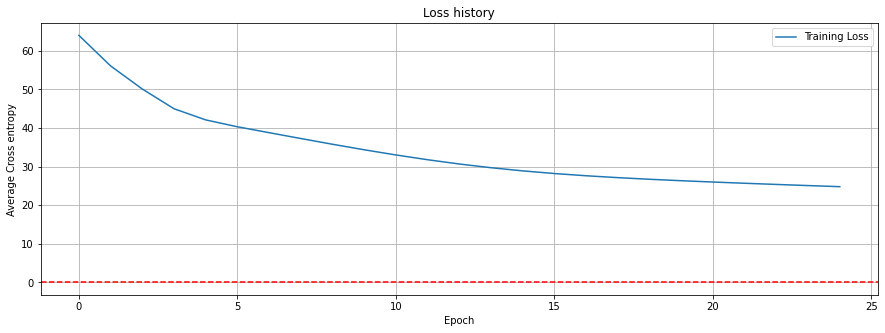

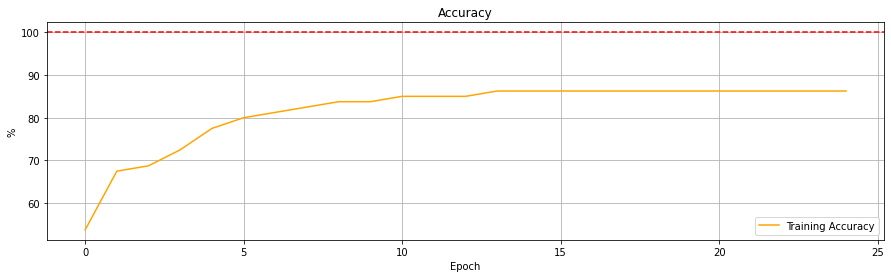

In [231]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, [], [], lr = 5e-2, steps = 25, batch_size = 16)


In [229]:
predictions = []
colors = []

for i in range(len(data)):
    predictions.append(qcnn_8(data[i][0],params)[1])
          
    if np.round(predictions[-1]) == 0:
        if i <= len(data)/2:
            colors.append('green')
        else:
            colors.append('red')
    else:
        if i <= len(data)/2:
            colors.append('red')
        else:
            colors.append('green')

Text(0.5, 1.0, 'Predictions of labels; J = 1')

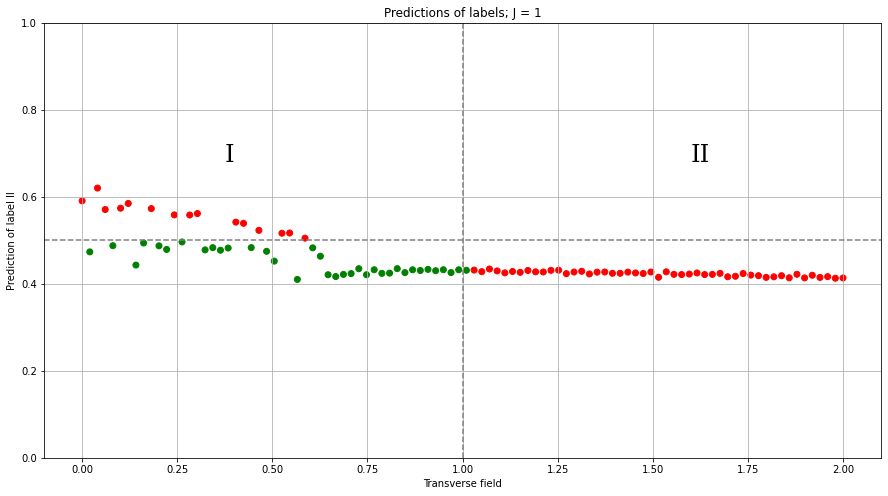

In [230]:
plt.figure(figsize=(15,8))
plt.xlim(-0.1,2.1)
plt.ylim(0,1)
plt.grid(True)
plt.axhline(y=.5, color='gray', linestyle='--')
plt.axvline(x=1, color='gray', linestyle='--')
plt.text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
plt.xlabel('Transverse field')
plt.ylabel('Prediction of label II')
plt.scatter(np.linspace(0,2,len(data)), predictions, c = colors)
plt.title('Predictions of labels; J = 1')

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)